In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import warnings
import pandas as pd
import zipfile
import shutil
import splitfolders
import wandb
from tqdm import trange
warnings.filterwarnings("ignore")
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.get_device_name(0)

/opt/conda/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


'Tesla V100-SXM3-32GB'

In [3]:
wandb.login()

True

In [4]:
for path_to_zip_file in ['train_imgs', 'test_imgs']:
    with zipfile.ZipFile(path_to_zip_file + '.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

In [4]:
df = pd.read_csv('test_labels.csv', names=['filename', 'label'])
filenames = df.filename[1:]
labels = df.label[1:]
filenames

In [5]:
for i in trange(1, len(filenames) + 1):
    source = 'test_imgs/' + filenames[i]
    if labels[i]:
        destination = 'test_src/fire'
    else:
        destination = 'test_src/not_fire'
    shutil.copy(source, destination)

In [6]:
splitfolders.ratio("src", output="data",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

In [5]:
SIZE = (448, 448)

transforms_train = transforms.Compose([
    # data augmentation
    transforms.Resize(SIZE),
    transforms.RandomAffine(15),
    transforms.RandomRotation(5),
    transforms.GaussianBlur(1),
    transforms.RandomAutocontrast(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True),
])

transforms_test = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
!rmdir data/train/.ipynb_checkpoints
!rmdir data/val/.ipynb_checkpoints

rmdir: failed to remove 'data/train/.ipynb_checkpoints': No such file or directory
rmdir: failed to remove 'data/val/.ipynb_checkpoints': No such file or directory


In [6]:
# train and test directories
train_dir = "src/"
test_dir = "test_src/"

In [7]:
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

# create train dataloader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=5,
)

# create test dataloader
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=5,
)

In [8]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print(class_names)
num_classes = len(class_names)
print('Number of classes:', num_classes)

Train dataset size: 2619
Test dataset size: 400
['fire', 'not_fire']
Number of classes: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


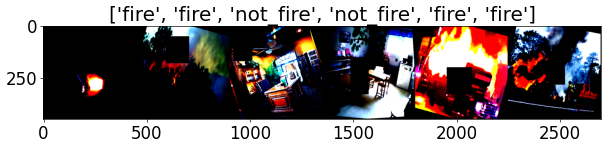

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    input = input.numpy().transpose((1, 2, 0))
    plt.imshow(input)
    plt.title(title)
    plt.show()

iterator = iter(train_dataloader)
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:6])
imshow(out, title=[class_names[x] for x in classes[:6]])

In [10]:
def train_model(name, model):
        
    start_time = time.time()
    wandb.init(
        project="gdsc",
        entity="steeldream",
        name=name,
        config={
            "lr": 3e-4,
            "model_name": name,
            "epochs": 8,
        }
    )
    config = wandb.config
    
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    model = model.to(device) 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    
    wandb.watch(model)
    
    curr_max_acc = 0
    for epoch in range(0, config.epochs):
    
        print(f"Epoch {epoch} running")
        model.train()
        running_loss = 0.
        running_corrects = 0 
        
        for i, (inputs, labels) in enumerate(train_dataloader):
            
            inputs = inputs.to(device)
            labels = labels.to(device) 
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data) 
            
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset) * 100.
        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s' \
              .format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

        model.eval()
        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            test_epoch_loss = running_loss / len(test_dataset)
            test_epoch_acc = running_corrects / len(test_dataset) * 100.
            print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s' \
                  .format(epoch, test_epoch_loss, test_epoch_acc, time.time() - start_time))
            metrics = {
                "test/loss": test_epoch_loss, 
                "test/accuracy": test_epoch_acc,
                "train/loss": epoch_loss, 
                "train/accuracy": epoch_acc,
            }    
            wandb.log(metrics) 

        if test_epoch_acc > curr_max_acc and test_epoch_acc > 96:
            curr_max_acc = test_epoch_acc
            path = f"saved_models/{name}-{SIZE[0]}-{curr_max_acc}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, path)

wandb.finish()

In [12]:
resnets = {
#     "resnext50_32": models.resnext50_32x4d(pretrained=True),
#     "resnext101_32": models.resnext101_32x8d(pretrained=True),
#     "wide_resnet50": models.wide_resnet50_2(pretrained=True),
    "wide_resnet101": models.wide_resnet101_2(pretrained=True),
#     "resnet50":  models.resnet50(pretrained=True),
#     "resnet101": models.resnet101(pretrained=True),
#     "resnet152": models.resnet152(pretrained=True),
}

for name, model in resnets.items():
    train_model(name, model)

test/accuracy,▁▆█
test/loss,▄█▁
train/accuracy,▁▆█
train/loss,█▃▁
test/accuracy,93.0
test/loss,0.20107
train/accuracy,98.54906
train/loss,0.04498


Epoch 0 running
[Train #0] Loss: 0.1737 Acc: 93.9672% Time: 99.4568s
[Test #0] Loss: 0.2171 Acc: 92.2500% Time: 104.9505s
Epoch 1 running
[Train #1] Loss: 0.1079 Acc: 96.2581% Time: 190.7546s
[Test #1] Loss: 0.2419 Acc: 91.2500% Time: 196.2773s
Epoch 2 running
[Train #2] Loss: 0.0999 Acc: 96.3345% Time: 282.0237s
[Test #2] Loss: 0.2623 Acc: 91.5000% Time: 287.5338s
Epoch 3 running
[Train #3] Loss: 0.0592 Acc: 98.0527% Time: 373.6445s
[Test #3] Loss: 0.3081 Acc: 93.0000% Time: 379.1718s
Epoch 4 running
[Train #4] Loss: 0.0614 Acc: 97.8618% Time: 465.2779s
[Test #4] Loss: 0.1723 Acc: 95.5000% Time: 470.8017s
Epoch 5 running
[Train #5] Loss: 0.0505 Acc: 98.2818% Time: 556.9745s
[Test #5] Loss: 0.2416 Acc: 93.2500% Time: 562.4675s
Epoch 6 running
[Train #6] Loss: 0.0614 Acc: 98.2436% Time: 648.2235s
[Test #6] Loss: 0.3172 Acc: 93.2500% Time: 653.6723s
Epoch 7 running
[Train #7] Loss: 0.0426 Acc: 98.5872% Time: 739.5216s
[Test #7] Loss: 0.4389 Acc: 91.5000% Time: 744.9908s
